<a href="https://colab.research.google.com/github/Spandan-Madan/A-Collection-of-important-tasks-in-pytorch/blob/master/uniform_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import random
import torch.nn as nn

In [2]:
import torch.distributions as D

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/github/differentiable_graphics_ml

/content/drive/MyDrive/github/differentiable_graphics_ml


In [5]:
import numpy as np

In [6]:
import cma
from tqdm.notebook import tqdm
import pickle

import matplotlib.pyplot as plt

In [7]:
import torch.nn.functional as F

In [8]:
def sample_uniform(batch_size, N_dim, r1, r2):
    random_matrix = (r1 - r2) * torch.rand([batch_size, N_dim]) + r2
    return random_matrix

In [9]:
class MLP(nn.Module):
    def __init__(self, data_dimensions,name):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(data_dimensions, int(data_dimensions)),
            nn.ReLU(),
#             nn.Linear(int(data_dimensions*5), int(data_dimensions/5)),
#             nn.ReLU(),
#             nn.Linear(int(data_dimensions), int(data_dimensions/5)),
#             nn.ReLU(),
#             nn.Linear(int(data_dimensions/5), int(data_dimensions/5)),
#             nn.ReLU(),
            nn.Linear(int(data_dimensions), 2)
        )
        self.name = name
        self.train_accuracy = 0
        self.test_accuracy = 0
        self.dataset = []

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

In [10]:
class CMA_info():
    def __init__(self, model_name, num_samples):
        super(CMA_info, self).__init__()
        self.model_name = model_name
        self.num_samples = num_samples
        
        self.distances = []
        self.in_dist_advs = []
        self.advs = []
        self.starts = []
    
    def summary(self):
        print('****************** CMA Summary *******************')
        print('Trained on %s points:'%self.model_name.split('_')[-1])
        print('Adversarials: %s/%s'%(len(self.advs), self.num_samples))
        print('In-distribution: %s/%s'%(len(self.in_dist_advs), len(self.advs)))
        
        avg_dist = np.mean(self.distances)
        print('Average L2 distance: %s'%(avg_dist))
        print('*'*50)

In [11]:
x1_min = -10
x1_max = 10

x2_min = 20
x2_max = 40

test_min = -1
test_max= 1

In [12]:
def make_dataset(dataset_size):
    sample_1 = sample_uniform(dataset_size, N_dim, x1_min, x1_max)
    sample_2 = sample_uniform(dataset_size, N_dim, x2_min, x2_max)
    
    labels_1 = torch.zeros(len(sample_1))
    labels_2 = torch.ones(len(sample_2))
    
    X = torch.vstack([sample_1, sample_2])
    Y = torch.hstack([labels_1, labels_2])
    ids = list(range(len(X)))

    random.shuffle(ids)
    train_ids = ids[:int(0.8*len(X))]
    test_ids = ids[int(0.8*len(X)):]

    # len(X)

    X_train = X[train_ids].cuda()
    X_test = X[test_ids].cuda()

    Y_train = Y[train_ids].cuda()
    Y_test = Y[test_ids].cuda()
    return X_train, X_test, Y_train, Y_test

In [13]:
def train_model(N_dim, dataset, name):
    X_train, X_test, Y_train, Y_test = dataset
    model = MLP(N_dim, name).cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
    loss_fn = nn.CrossEntropyLoss()
    model.dataset = dataset
    
    for epoch in tqdm(range(1000)): 
        outputs = model(X_train)
        loss = loss_fn(outputs, Y_train.long())
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(model(X_test), dim=1)
        accuracy = torch.sum(predictions == Y_test)/len(Y_test)
        
        train_predictions = torch.argmax(model(X_train), dim=1)
        train_accuracy = torch.sum(train_predictions == Y_train)/len(Y_train)

        if epoch == 999:
            print("Epoch:%s, Train Acc:%s"%(epoch, train_accuracy))
            print("Epoch:%s, Test Acc:%s"%(epoch, accuracy))
        
        model.test_accuracy = accuracy
        model.train_accuracy = train_accuracy
    
    return model

In [14]:
def batched_train_model(N_dim, dataset, name):
    X_train, X_test, Y_train, Y_test = dataset
    model = MLP(N_dim, name).cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
    loss_fn = nn.CrossEntropyLoss()
    model.dataset = dataset
    
    BATCH_SIZE = 64000
    
    for epoch in tqdm(range(1000)):
        num_batches = int(X_train.shape[0]/(BATCH_SIZE))
        
        batch_accuracies = []
        batch_train_accuracies = []
        for batch_num in range(num_batches):
            start_pt = BATCH_SIZE * batch_num
            end_pt = start_pt + BATCH_SIZE
            train_X = X_train[start_pt:end_pt]
            train_Y = Y_train[start_pt:end_pt]
            test_X = X_test
            test_Y = Y_test

            outputs = model(train_X)
            loss = loss_fn(outputs, train_Y.long())
            loss.backward()
            optimizer.step()

            batch_predictions = torch.argmax(model(test_X), dim=1)
            batch_accuracy = torch.sum(batch_predictions == test_Y)/len(test_Y)
            batch_accuracies.append(batch_accuracy.item())
            
            batch_train_predictions = torch.argmax(model(train_X), dim=1)
            batch_train_accuracy = torch.sum(batch_train_predictions == train_Y)/len(train_Y)
            batch_train_accuracies.append(batch_train_accuracy.item())        
        
        accuracy = np.mean(batch_accuracies)
        train_accuracy = np.mean(batch_train_accuracies)

        
        if epoch%100 == 0:
            print("Epoch:%s, Train Acc:%s"%(epoch, train_accuracy))
            print("Epoch:%s, Test Acc:%s"%(epoch, accuracy))
        
        if epoch == 999:
            print("Epoch:%s, Train Acc:%s"%(epoch, train_accuracy))
            print("Epoch:%s, Test Acc:%s"%(epoch, accuracy))
        
        model.test_accuracy = accuracy
        model.train_accuracy = train_accuracy
    
    return model

In [15]:
#### Tests for generating and training image models####

# image_test_data = make_dataset(1000, True)
# image_test_model = train_model(N_dim, image_test_data, 'dset_size_%s'%dsize, True)

# CMA failures

In [16]:
# def cma_objective(x_input):
#     torch_x = torch.from_numpy(x_input).unsqueeze(0).float()
#     if 'LeNet' in CURRENT_MODEL.name
#     output = CURRENT_MODEL(torch_x)
#     pred_prob = output[0][CATEGORY_NUM].item()
#     prediction = torch.argmax(output[0]).item()
#     return pred_prob, prediction

In [17]:
# torch.vstack([start_pos[0].unsqueeze(0), start_pos[0].unsqueeze(0), start_pos[0].unsqueeze(0)]).shape

In [18]:
def cma_objective(x_input):
    torch_x = torch.from_numpy(x_input).unsqueeze(0).float()
#     try:
#         if 'LeNet' in CURRENT_MODEL.name:
#             side_size = int(np.sqrt(N_dim))
#             torch_x = torch.from_numpy(x_input).reshape(1,1,side_size,side_size).float()
#         else:
#             torch_x = torch.from_numpy(x_input).unsqueeze(0).float()
#     except:
#         side_size = int(np.sqrt(int(N_dim/3)))
#         torch_x_channel = torch.from_numpy(x_input).reshape(1,3,side_size,side_size).float()
#         torch_x = torch.vstack([torch_x_channel, torch_x_channel, torch_x_channel]).cuda()
        
    output = CURRENT_MODEL(torch_x)
    pred_prob = output[0][CATEGORY_NUM].item()
    prediction = torch.argmax(output[0]).item()
    return pred_prob, prediction

In [19]:
def cma_experiment(attacked_model, num_samples = 50):
    cma_search_output = {}
    global CURRENT_MODEL
    CURRENT_MODEL = attacked_model
    print(CURRENT_MODEL.name)
    cma_output = CMA_info(CURRENT_MODEL.name, num_samples)        
    
    for i in tqdm(range(num_samples)):
        initial_pred = 1
        while initial_pred == 1:
            start_pos = sample_uniform(1, N_dim, test_min, test_max)
            output = CURRENT_MODEL(start_pos)
            initial_pred = torch.argmax(output[0]).item()
        cma_output.starts.append(start_pos)
        start_pos = start_pos[0]
        
        es = cma.CMAEvolutionStrategy(start_pos, 0.00005)
        es.optimize(cma_objective, verb_disp = False, iterations=1500, correct_prediction = CATEGORY_NUM)
        adv_offspring_ids = np.where(np.array(es.predictions) != 0)
        
        if len(adv_offspring_ids[0]) > 0:
            random_adv_offspring_id = random.choice(list(adv_offspring_ids[0]))
            random_adv_offspring = es.prediction_settings[random_adv_offspring_id]
            cma_output.advs.append(random_adv_offspring)        

            max_val = np.max(random_adv_offspring)
            if max_val < x1_max:
                cma_output.in_dist_advs.append(random_adv_offspring)
                distance = np.linalg.norm(start_pos - random_adv_offspring)
                cma_output.distances.append(distance)
    return cma_output

In [20]:
CATEGORY_NUM = 0
CURRENT_MODEL = None

N_dim = 100

In [21]:
# all_info[-1]

In [22]:
# all_info[0]

### CMA attack accuracy vs Dataset size

In [23]:
all_info = []

In [ ]:
for iteration in range(10):
    print('*'*50)
    print('Iteration %s'%iteration)
    print('*'*50)
    
    trained_models = {}
    attack_output = {}
    for dsize in [10000, 100000]:
        print('Working with with %s'%dsize)
        dset = make_dataset(dsize)
        if dsize > 64000:
            trained_models[dsize] = batched_train_model(N_dim, dset, 'dset_size_%s'%dsize)
        else:
            trained_models[dsize] = train_model(N_dim, dset, 'dset_size_%s'%dsize)
        model_to_attack = trained_models[dsize].cpu()
        attack_output[dsize] = cma_experiment(model_to_attack, 50)
    iter_info = [trained_models, attack_output]
    all_info.append(iter_info)

**************************************************
Iteration 0
**************************************************
Working with with 10000


In [ ]:
with open('dataset_size_experiments.p','wb') as F:
    pickle.dump(all_info, F)

In [49]:
# trained_models[1024000].test_accuracy

In [ ]:
# all_info[0][0][1024000] = all_info[1][0][1024000]

In [ ]:
# all_info[0][1][1024000] = all_info[1][1][1024000]

In [ ]:
# all_info[1]

In [ ]:
all_info[0][1]

In [ ]:
attack_per_dset_size = {}
for key in all_info[0][1].keys():
    adv_count = len(all_info[0][1][key].advs)
    start_count = len(all_info[0][1][key].starts)
    attack_rate = adv_count/start_count*100
    attack_per_dset_size[key] = attack_rate

In [ ]:
attack_per_dset_size

{4000: 100.0, 16000: 100.0, 64000: 100.0, 256000: 100.0, 1024000: 100.0}

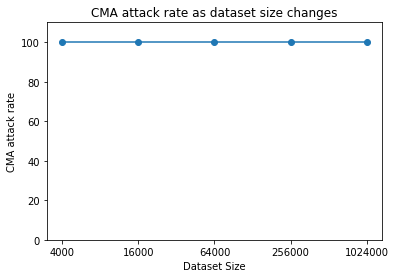

In [ ]:
plt.plot(attack_per_dset_size.values(), marker='o')
plt.xticks(list(range(len(attack_per_dset_size.keys()))), labels = attack_per_dset_size.keys())
plt.ylim(0,110)
plt.title('CMA attack rate as dataset size changes')
plt.xlabel('Dataset Size')
plt.ylabel('CMA attack rate')
plt.show()

In [ ]:
##### Execute because used extensively below #####
def predict(model, point):
    prepped_point = torch.from_numpy(point).cuda().float().unsqueeze(0)
    prediction = torch.argmax(model(prepped_point)[0]).item()
    return prediction

# Impact of Dimensionality

In [ ]:
all_info = []

In [ ]:
for iteration in range(1):
    print('*'*50)
    print('Iteration %s'%iteration)
    print('*'*50)
    
    trained_models = {}
    attack_output = {}
    for N_dim in [5000]:
        print('Working with with %s dimensions'%N_dim)
        dsize = 10000
        dset = make_dataset(dsize)
        trained_models[N_dim] = train_model(N_dim, dset, 'dset_size_%s'%dsize)
        model_to_attack = trained_models[N_dim].cpu()
        attack_output[N_dim] = cma_experiment(model_to_attack, 10)
    iter_info = [trained_models, attack_output]
    all_info.append(iter_info)

**************************************************
Iteration 0
**************************************************
Working with with 5000 dimensions


  0%|          | 0/100 [00:00<?, ?it/s]

dset_size_10000


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
len(attack_output[5000].in_dist_advs)

0

In [ ]:
len(attack_output[1000].in_dist_advs)

10

In [ ]:
len(attack_output[100].in_dist_advs)

10

In [ ]:
len(attack_output[50].in_dist_advs)

10

In [ ]:
len(attack_output[100].in_dist_advs)

10

In [ ]:
len(attack_output[250].in_dist_advs)

10

In [ ]:
len(attack_output[500].in_dist_advs)

6

In [ ]:
len(attack_output[1000].in_dist_advs)

10

In [ ]:
len(attack_output[2500].in_dist_advs)

In [ ]:
attack_per_dset_dim = {}
for key in iter_info[1].keys():
    adv_count = len(iter_info[1][key].advs)
    start_count = len(iter_info[1][key].starts)
    attack_rate = adv_count/start_count*100
    attack_per_dset_dim[key] = attack_rate

In [ ]:
plt.plot(attack_per_dset_dim.values(), marker='o')
plt.xticks(list(range(len(attack_per_dset_dim.keys()))), labels = attack_per_dset_dim.keys())
plt.ylim(0,110)
plt.title('CMA attack rate as dataset size changes')
plt.xlabel('Dataset Size')
plt.ylabel('CMA attack rate')
plt.show()

# Does Pooling solve the problem?

In [ ]:
def predict(model, point):
    prepped_point = torch.from_numpy(point).cuda().float().unsqueeze(0)
    prediction = torch.argmax(model(prepped_point)[0]).item()
    return prediction

In [ ]:
print('****** This is a sanity check *******')
for i in range(5):
    random_point = sample_uniform(1, N_dim, test_min, test_max)
    pred_out = predict(model_to_attack.cuda(), np.array(random_point[0]))
    print('Randomly sampled a point from the test_min, test_max range....')
    print('Prediction is %s'%pred_out)
print('****** Should be a lot 0s predicted above*****')

****** This is a sanity check *******
Randomly sampled a point from the test_min, test_max range....
Prediction is 0
Randomly sampled a point from the test_min, test_max range....
Prediction is 0
Randomly sampled a point from the test_min, test_max range....
Prediction is 0
Randomly sampled a point from the test_min, test_max range....
Prediction is 0
Randomly sampled a point from the test_min, test_max range....
Prediction is 0
****** Should be a lot 0s predicted above*****


In [ ]:
predict(model_to_attack.cuda(), all_info[0][1][10000].advs[1])

1

##### Let's try to fix this by randomly perturbing the adversarial

In [ ]:
pert_to_recovery = {}
for repeats in range(5):
    for p in np.arange(0.05,0.3,0.05):
        all_top_preds = []
        for i in range(50):
            adv_sample = all_info[0][1][10000].advs[i]

            all_preds = []
            for i in range(10):
                perturb_min = -p
                perturb_max = p
                perturb_vector = np.array(sample_uniform(1, N_dim, perturb_min, perturb_max)[0])
                perturbed_sample = adv_sample + perturb_vector
                perturbed_prediction = predict(model_to_attack.cuda(), perturbed_sample)
                all_preds.append(perturbed_prediction)
            top_pred = max(set(all_preds), key = all_preds.count)

            all_top_preds.append(top_pred)

        recovered_acc = (1 - np.sum(all_top_preds)/50)*100
        if "%.02f"%p in pert_to_recovery.keys():
            pert_to_recovery["%.02f"%p].append(recovered_acc)
        else:
            pert_to_recovery["%.02f"%p] = [recovered_acc]
#         print('Recovered %s%% samples by random perturbation.'%recovered_acc)

In [ ]:
np.linalg.norm(perturb_vector)

1.4335177

In [ ]:
mean_perfs = np.mean(np.array(list(pert_to_recovery.values())),axis=1)
std_perfs = np.std(np.array(list(pert_to_recovery.values())),axis=1)

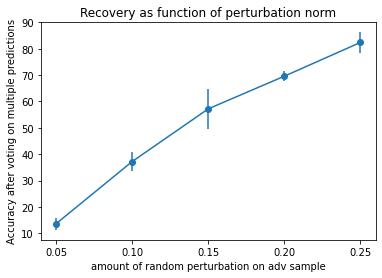

In [ ]:
plt.errorbar([0,1,2,3,4], mean_perfs, std_perfs, marker='o')
plt.title('Recovery as function of perturbation norm')
plt.xlabel('amount of random perturbation on adv sample')
plt.ylabel('Accuracy after voting on multiple predictions')
plt.xticks([0,1,2,3,4],labels=list(pert_to_recovery.keys()))
plt.show()

#### Lets see the norm of adversarial perturbation: how much is needed if the direction was known.

In [ ]:
adv_point = all_info[0][1][10000].advs[1]
start_point = np.array(all_info[0][1][10000].starts[1])

In [ ]:
adv_vec = adv_point - start_point

In [ ]:
np.linalg.norm(adv_vec)

2.9962379296577284

In [ ]:
np.linalg.norm(adv_point)

5.389204731238513

In [ ]:
np.linalg.norm(start_point)

5.800697

# Church Window Plots

In [ ]:
def perpendicular_vector(v):
    random_vector = np.random.randn(N_dim)
    orthogonal = random_vector - random_vector.dot(v)*v/np.linalg.norm(v)**2
    orthogonal_normalized = orthogonal/np.linalg.norm(orthogonal) * np.linalg.norm(v)
    return orthogonal_normalized

def plot_church_window(start_point, adv_point):
    adv_vector = adv_point - start_point
    orthogonal_vector = perpendicular_vector(adv_vector)


    ##### Collect Predictions ######
    predictions = np.zeros((40,40))

    row_num = 0
    col_num = 0

    for alpha in np.arange(0, 2.0, 0.05):
        for beta in np.arange(0, 2.0, 0.05):
            curr_point = start_point + beta*adv_vector + alpha*orthogonal_vector
            curr_pred = predict(model, curr_point)
            predictions[row_num][col_num] = curr_pred
            col_num += 1
        row_num += 1
        col_num = 0

    ##### Plot ######
    plt.imshow(predictions, cmap=custom_cmap)
    plt.xlim([0, 40])
    plt.ylim([0, 40])
    plt.title('Church Window Plot')
    plt.xticks(range(0,40,5), labels = np.arange(0,2,0.25))
    plt.yticks(range(0,40,5), labels = np.arange(0,2,0.25))
    plt.xlabel('Adversarial Direction')
    plt.ylabel('Orthogonal Direction')
    plt.show()

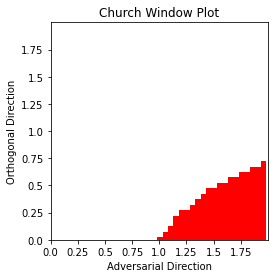

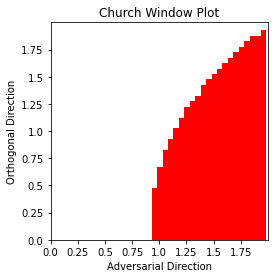

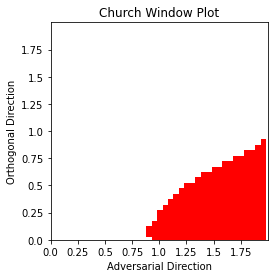

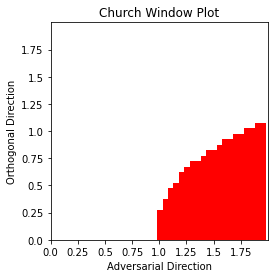

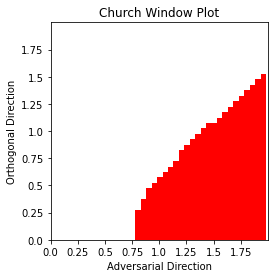

In [ ]:
DSIZE = 10000


from matplotlib import colors

custom_cmap = colors.ListedColormap(['white', 'red'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, custom_cmap.N)

model = all_info[0][0][DSIZE].cuda()

for i in range(5):
    adv_point = all_info[0][1][DSIZE].in_dist_advs[i]
    start_point = all_info[0][1][DSIZE].starts[i]
    start_point = np.array(start_point)[0]
    plot_church_window(start_point, adv_point)

# Nearest neighbor analysis

In [ ]:
starting_points = all_info[0][1][10000].starts
in_dist_advs_points = all_info[0][1][10000].in_dist_advs

In [ ]:
training_points = all_info[0][0][10000].dataset[0]

In [ ]:
start_neighbor_distances = []
for start_p in starting_points:
    distances = torch.sum((training_points - start_p.cuda())**2, dim = 1)
    neighbors = torch.argsort(distances)[:10].cpu()
    neighbor_distance = torch.sum(distances[neighbors]).item()
    start_neighbor_distances.append(neighbor_distance)

In [ ]:
adv_neighbor_distances = []
for adv_p in in_dist_advs_points:
    distances = torch.sum((training_points - torch.from_numpy(adv_p).cuda())**2, dim = 1)
    neighbors = torch.argsort(distances)[:10].cpu()
    neighbor_distance = torch.sum(distances[neighbors]).item()
    adv_neighbor_distances.append(neighbor_distance)

(array([ 2.,  3., 24., 40., 45., 47., 24., 10.,  4.,  1.]),
 array([ 9915.65136719,  9974.9921875 , 10034.33300781, 10093.67382812,
        10153.01464844, 10212.35546875, 10271.69628906, 10331.03710938,
        10390.37792969, 10449.71875   , 10509.05957031]),
 <BarContainer object of 10 artists>)

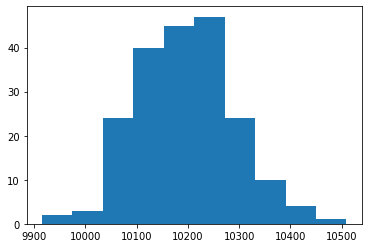

In [ ]:
plt.hist(start_neighbor_distances)

(array([ 3.,  7., 27., 39., 52., 34., 23., 10.,  4.,  1.]),
 array([ 9939.33247206,  9988.23968375, 10037.14689545, 10086.05410715,
        10134.96131885, 10183.86853054, 10232.77574224, 10281.68295394,
        10330.59016564, 10379.49737733, 10428.40458903]),
 <BarContainer object of 10 artists>)

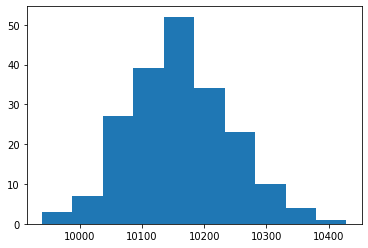

In [ ]:
plt.hist(adv_neighbor_distances)

In [ ]:
np.mean(adv_neighbor_distances)

10160.343138349179

In [ ]:
np.mean(start_neighbor_distances)

10196.771958007812

In [ ]:
np.std(adv_neighbor_distances)

81.89637551160129

In [ ]:
np.std(start_neighbor_distances)

94.20267086666723

# Adversarial Training analysis

### Collect adv points (25% of training data size)

In [ ]:
attack_output_2 = {}

In [ ]:
attack_output_2[dsize] = cma_experiment(model_to_attack, 4000)

dset_size_10000


  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
# with open('inof.p', 'wb') as F:
#     pickle.dump(attack_output_2, F)

In [ ]:
augmented_training_data = torch.vstack([training_points, torch.tensor(attack_output_2[dsize].in_dist_advs).float().cuda()])

### Train with them

In [ ]:
training_labels = dset[2]

In [ ]:
augmented_training_labels = torch.hstack([training_labels, torch.zeros(4000).long().cuda()])

In [ ]:
# augmented_training_labels[-1]

In [ ]:
dset_new = [augmented_training_data, dset[1], augmented_training_labels, dset[3]] 

In [ ]:
adv_trained_models = {}

In [ ]:
adv_attack_output = {}

In [ ]:
# dset = make_dataset(dsize)
adv_trained_models[dsize] = train_model(N_dim, dset_new, 'dset_size_%s_adv'%dsize)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:999, Train Acc:tensor(1., device='cuda:0')
Epoch:999, Test Acc:tensor(1., device='cuda:0')


In [ ]:
# adv_trained_models[10000].dataset[0].shape

In [ ]:
adv_model_to_attack = adv_trained_models[dsize].cpu()
adv_attack_output[dsize] = cma_experiment(adv_model_to_attack, 50)

dset_size_10000_adv


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# len(adv_attack_output[dsize].in_dist_advs)

# Aggregate evaluation

In [ ]:
all_distances = {}
in_dists = {}

In [ ]:
# all_info[0][1][dsize].in_dist_advs

In [ ]:
for dsize in [1000, 100000]:
    all_distances[dsize] = []
    in_dists[dsize] = []
    for i in range(1):
        in_dists[dsize].append(len(all_info[i][1][dsize].in_dist_advs))
        all_distances[dsize].append(np.nanmean(all_info[i][1][dsize].distances))

In [ ]:
# all_distances.keys()

In [ ]:
for key in all_distances.keys():
    print(np.nanmean(all_distances[key]))

3.2171293443927995
5.13962748088732


In [ ]:
for key in in_dists.keys():
    print(np.mean(in_dists[key]))

10.0
10.0


In [ ]:
def predict(model, point):
    prepped_point = torch.from_numpy(point).cuda().float().unsqueeze(0)
    prediction = torch.argmax(model(prepped_point)[0]).item()
    return prediction

# Sensitivity Analysis

In [ ]:
DSIZE = 1000

In [ ]:
mod = all_info[0][0][DSIZE].cuda()

In [ ]:
def min_subset(start, adv, mod, start_id = 0):
    for i in range(start_id, start_id + 50):
        index = i%50
        start[:index] = adv[:index]
        start_pred = predict(mod, start)
        adv_pred = predict(mod, adv)
        if start_pred == adv_pred:
            break
    return index        
#     print('Broke at %i'%index)

In [ ]:
broken_changes = []
for i in range(10):
    adv_point = all_info[0][1][DSIZE].in_dist_advs[i]
    start_point = all_info[0][1][DSIZE].starts[i]
    start_point = np.array(start_point)[0]
    broken_change = min_subset(start_point, adv_point, mod, random.choice(list(range(50))))
    broken_changes.append(broken_change)

In [ ]:
print(np.mean(broken_changes))
print(np.std(broken_changes))

44.1
6.057227088363123


# Opposite change

In [ ]:
with open('info_iters.p','rb') as F:
    all_info = pickle.load(F)

In [ ]:
def min_subset_reform(start, adv, mod, start_id = 0):
    for i in range(start_id, start_id + 50):
        index = i%50
        adv[:index] = start[:index]
        start_pred = predict(mod, start)
        adv_pred = predict(mod, adv)
        if start_pred == adv_pred:
            break
    return index

In [ ]:
broken_changes = []
for i in range(50):
    adv_point = all_info[0][1][DSIZE].in_dist_advs[i]
    start_point = all_info[0][1][DSIZE].starts[i]
    start_point = np.array(start_point)[0]
    broken_change = min_subset_reform(start_point, adv_point, mod, random.choice(list(range(50))))
    broken_changes.append(broken_change)

In [ ]:
print(np.mean(broken_changes))
print(np.std(broken_changes))

24.18
13.122027282398097


# Random Perturb

In [ ]:
with open('info_iters.p','rb') as F:
    all_info = pickle.load(F)

In [ ]:
def min_subset_random(start, adv, mod, start_id = 0):
    for i in range(start_id, start_id + 50):
        index = i%50
        start[index] = np.random.normal(loc=np.mean(start[index]),scale=np.std(start[index]))
        start_pred = predict(mod, start)
        adv_pred = predict(mod, adv)
        if start_pred == adv_pred:
            break
    return index

In [ ]:
broken_changes = []
for i in range(50):
    adv_point = all_info[0][1][DSIZE].in_dist_advs[i]
    start_point = all_info[0][1][DSIZE].starts[i]
    start_point = np.array(start_point)[0]
    broken_change = min_subset_random(start_point, adv_point, mod, random.choice(list(range(50))))
    broken_changes.append(broken_change)

In [ ]:
print(np.mean(broken_changes))
print(np.std(broken_changes))

28.98
12.657788116412757
